# Blackjack Card Point Detection Project 🃏
### Ahmed Adnan, Eugen Erb, Nicolas Huhle

This notebook **detects** and **recognizes** playing cards to compute blackjack scores using:

**Image preprocessing**: grayscale, Gaussian blur, and Canny edge detection

**Contour detection**: find large quadrilaterals (cards)

**Classification**: split cards into dealer vs. player by vertical position

**Sorting**: order cards left→right

**Perspective warp**: transform each card to a 200×300 front‐facing view

**Template matching**: match warped cards to rank templates using normalized cross‐correlation, gradient‐based structural similarity, and histogram correlation

**Blackjack scoring**: assign rank values, adjust Aces, and compute final hand totals for dealer and player

In [20]:
# Core image‐processing libraries
import cv2                         # OpenCV for computer vision routines
import numpy as np                # NumPy for numerical arrays
import matplotlib.pyplot as plt   # Matplotlib for plotting
from matplotlib.patches import Rectangle  # For drawing rectangles later if needed

# File handling (if we want to read multiple files later)
import glob
import os

# Configure matplotlib for better readability in notebook
plt.rcParams['figure.figsize'] = (12, 8)   # default figure size
plt.rcParams['image.cmap'] = 'gray'        # default colormap (grayscale)

print("Libraries loaded:")
print(" • OpenCV version:", cv2.__version__)
print(" • NumPy version :", np.__version__)


Libraries loaded:
 • OpenCV version: 4.11.0
 • NumPy version : 2.2.6


### Image Loading & Preprocessing

- Load the input image and check for errors to ensure downstream steps won’t fail.
- Convert to RGB for correct color display in Matplotlib.
- Generate a grayscale, blurred, and edge-detected version to verify the image is ready for contour detection.
- Visualize these stages so we can confirm everything processed correctly before moving on.


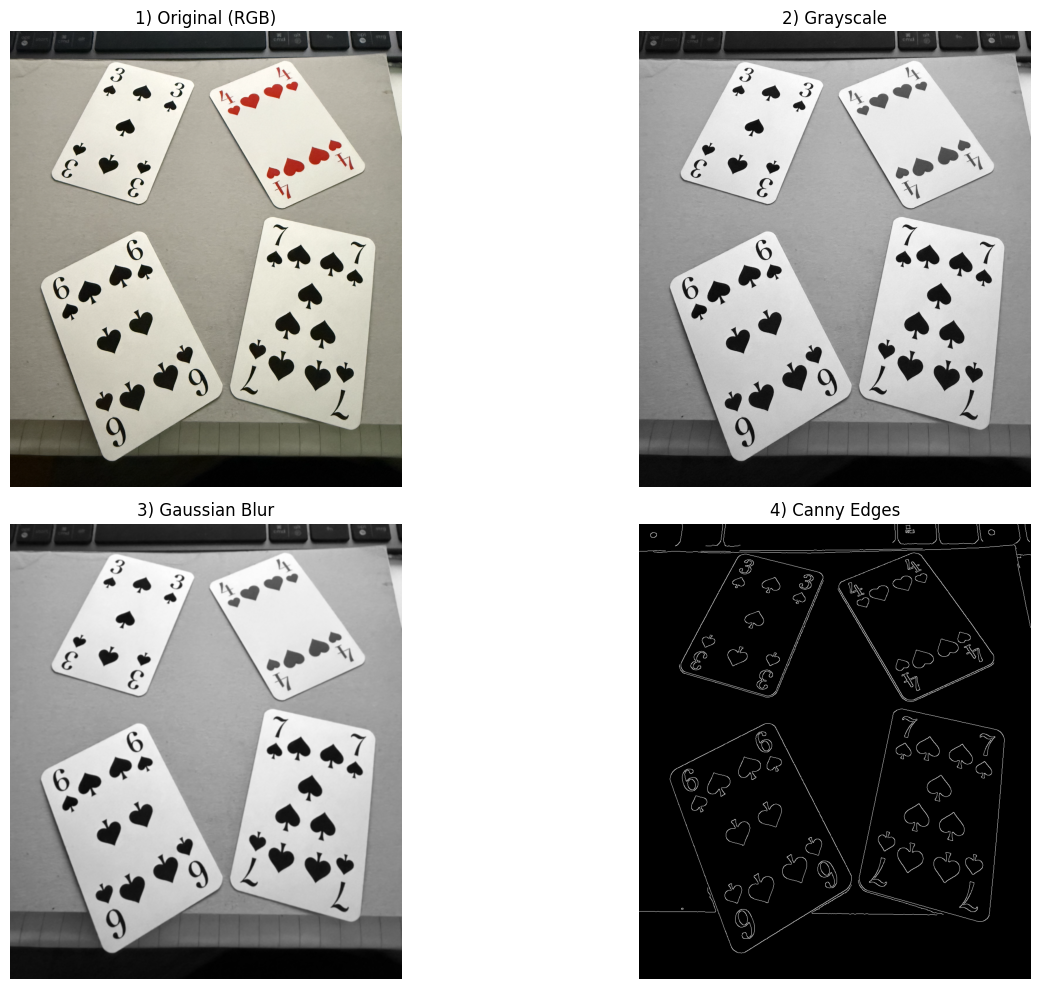

Preprocessing summary:
 • Original image shape: (1122, 966, 3) (H×W×3)
 • Grayscale shape    : (1122, 966) (H×W)
 → Ready for contour finding.


In [21]:
# 1. Load the input image (in BGR format, since OpenCV reads in BGR)
image_path = 'rotated.png'
original_bgr = cv2.imread(image_path)

if original_bgr is None:
    # If the image failed to load, give a helpful error
    print(f"Error: Could not load image from '{image_path}'.")
    print("Please check that your image is in the current directory.")
else:
    # Convert BGR → RGB for plotting with matplotlib
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale for processing
    gray = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2GRAY)
    
    # Apply a small Gaussian blur to reduce noise before edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Canny to detect edges (tunable thresholds: 50 and 150)
    edges = cv2.Canny(blurred, 50, 150)
    
    # 2×2 grid to show each processing step
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].imshow(original_rgb)
    axes[0, 0].set_title('1) Original (RGB)')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(gray, cmap='gray')
    axes[0, 1].set_title('2) Grayscale')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(blurred, cmap='gray')
    axes[1, 0].set_title('3) Gaussian Blur')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(edges, cmap='gray')
    axes[1, 1].set_title('4) Canny Edges')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of shapes for debugging
    print("Preprocessing summary:")
    print(f" • Original image shape: {original_bgr.shape} (H×W×3)")
    print(f" • Grayscale shape    : {gray.shape} (H×W)")
    print(" → Ready for contour finding.")


### Detect & Highlight Card Contours

- Find all external contours in the edge map to locate potential card outlines.  
- Filter contours to keep only large quadrilaterals (four corners, area > 10,000), which likely correspond to cards.  
- Draw these detected card contours in green on a copy of the original image.  
- Display the result so we can verify that only card‐shaped regions are being identified before proceeding.  
- Print the total count of detected card contours for reference.  


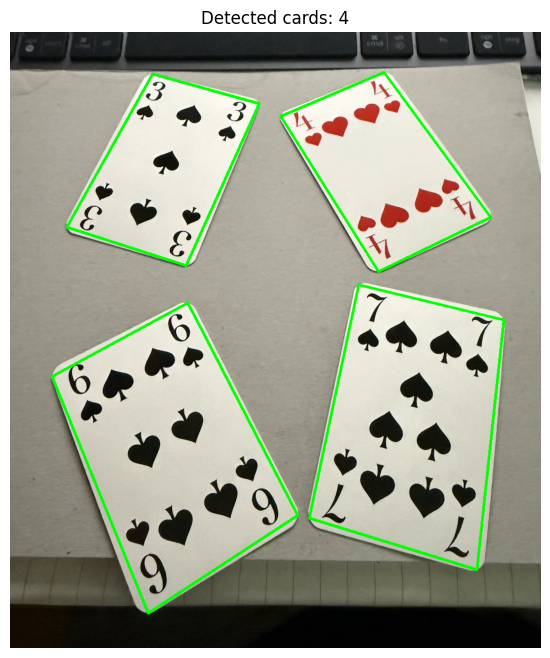

Number of card‐shaped contours detected: 4


In [22]:
# 1. Find all external contours in the binary edges image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 2. Filter: keep only quadrilaterals with area > min_area (likely cards)
card_contours = []
min_area = 10000  # adjust if your cards are much smaller or larger

for cnt in contours:
    # Perimeter of contour
    peri = cv2.arcLength(cnt, True)
    # Approximate the contour by a polygon with fewer points
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    # If polygon has 4 vertices and area is large, treat as a card
    if len(approx) == 4 and cv2.contourArea(cnt) > min_area:
        card_contours.append(approx)

# 3. Draw all detected card‐like contours on a copy of the original (RGB) image
contour_img = original_rgb.copy()
for cnt in card_contours:
    cv2.drawContours(contour_img, [cnt], -1, (0, 255, 0), 4)  # green outlines

# 4. Show the result
plt.figure(figsize=(10, 8))
plt.imshow(contour_img)
plt.title(f'Detected cards: {len(card_contours)}')
plt.axis('off')
plt.show()

print("Number of card‐shaped contours detected:", len(card_contours))


### Classify Cards into Dealer vs. Player

- Compute each contour’s centroid (center) to determine its vertical position in the image.  
- Split contours into two groups:  
  - Dealer cards: centroids in the upper half of the image  
  - Player cards: centroids in the lower half of the image  
- Print the count of dealer‐side and player‐side contours for verification.  
- Overlay dealer contours in red and player contours in blue on the original image to confirm correct grouping visually.  


In [23]:
def classify_card_contours(contours, image_shape, num_players=1):
    """
    Split a list of 4-point contours into:
      • dealer_contours  (upper half of image)
      • players_contours (list of length num_players):
         – if num_players==1: all bottom-half cards go to players_contours[0]
         – if num_players==2: bottom-half cards with centroid x>=mid go to players_contours[0] (Player 1, right),
                              those with x<mid go to players_contours[1] (Player 2, left)
    """
    h, w = image_shape[:2]
    dealer = []
    bottom = []
    # first separate upper vs bottom
    for cnt in contours:
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX = int(M["m10"]/M["m00"])
            cY = int(M["m01"]/M["m00"])
        else:
            x,y,ww,hh = cv2.boundingRect(cnt)
            cX = x + ww//2
            cY = y + hh//2
        if cY < h/2:
            dealer.append(cnt)
        else:
            bottom.append((cnt, cX))
    # now assign bottom to players
    if num_players == 1:
        # everything to player 1
        player1 = [cnt for cnt,_ in bottom]
        return dealer, [player1]
    elif num_players == 2:
        # split left vs right by mid-line
        player1 = [cnt for cnt,x in bottom if x >= w/2]   # right side → P1
        player2 = [cnt for cnt,x in bottom if x <  w/2]   # left side  → P2
        return dealer, [player1, player2]
    else:
        raise ValueError("num_players must be 1 or 2")

Dealer cards: 2
Player 1 cards: 2


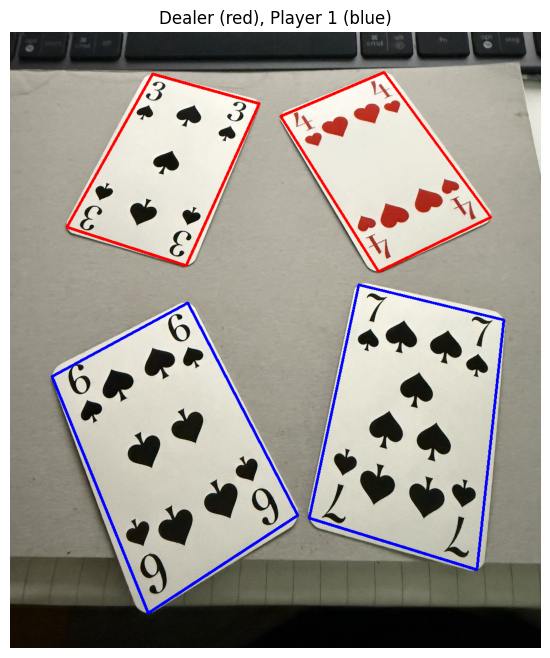

In [37]:
# ------------------------------------------------------------------------------
# Cell 4: Classify into dealer + 1 or 2 players
# ------------------------------------------------------------------------------
num_players = 1    # or 1
dealer_contours, players_contours = classify_card_contours(
    card_contours,
    original_bgr.shape,
    num_players
)

# players_contours is a list:
#   when num_players==1: [ player1_contours ]
#   when num_players==2: [ player1_contours, player2_contours ]
player1_contours = players_contours[0]
if num_players == 2:
    player2_contours = players_contours[1]

print(f"Dealer cards: {len(dealer_contours)}")
print(f"Player 1 cards: {len(player1_contours)}")
if num_players == 2:
    print(f"Player 2 cards: {len(player2_contours)}")

# Visual check (dealer:red, P1:blue, P2:yellow)
visual = original_rgb.copy()
for cnt in dealer_contours:
    cv2.drawContours(visual, [cnt], -1, (255,0,0), 3)
for cnt in player1_contours:
    cv2.drawContours(visual, [cnt], -1, (0,0,255), 3)
if num_players == 2:
    for cnt in player2_contours:
        cv2.drawContours(visual, [cnt], -1, (0,255,255), 3)

plt.figure(figsize=(10,8))
plt.imshow(visual)
plt.title('Dealer (red), Player 1 (blue)' + (', Player 2 (yellow)' if num_players==2 else ''))
plt.axis('off')
plt.show()


### Sort Card Contours Left→Right

- Define a helper function that finds the leftmost x-coordinate of each contour, so we can sort by horizontal position.  
- Sort all detected card contours from left to right based on that leftmost point.  
- Overlay each sorted contour on the original image and label them “1, 2, 3, …” at their top-left corner.  
- Display the result to confirm that cards are in the correct order for subsequent steps (e.g., warping and ranking).  


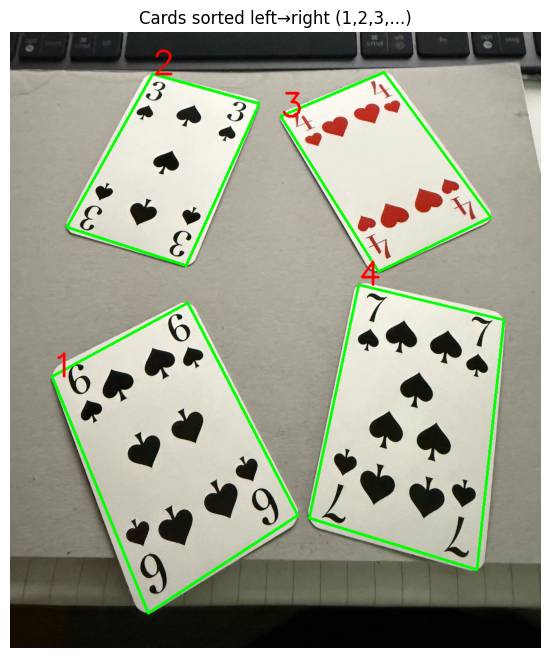

Card contours now sorted left to right for subsequent steps.


In [38]:
def get_leftmost_x(contour):
    """
    Return the smallest x‐coordinate among the 4 corner points of this contour.
    Used as a key for left‐to‐right sorting.
    """
    pts = contour.reshape(4, 2)       # shape (4,2)
    return np.min(pts[:, 0])          # minimum x among the 4 vertices

# Sort the full card list left→right
card_contours = sorted(card_contours, key=get_leftmost_x)

# Draw them in sorted order, with a label “1, 2, 3, …”
sorted_img = original_rgb.copy()
for idx, cnt in enumerate(card_contours):
    # Outline the contour in bright green
    cv2.drawContours(sorted_img, [cnt], -1, (0, 255, 0), 4)
    
    # Find the top‐left corner to place the index number
    pts = cnt.reshape(4, 2)
    top_left = pts[np.argmin(pts[:, 0] + pts[:, 1])]
    
    # Put a big blue number at that corner
    cv2.putText(
        sorted_img,
        str(idx + 1),
        tuple(top_left),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,                          # font scale
        (255, 0, 0),                # blue in BGR
        4                           # thickness
    )

plt.figure(figsize=(10, 8))
plt.imshow(sorted_img)
plt.title('Cards sorted left→right (1,2,3,...)')
plt.axis('off')
plt.show()

print("Card contours now sorted left to right for subsequent steps.")


### Prepare for Perspective Warp & Sort within Groups

- Define `order_points` to rearrange 4 corner coordinates into a consistent order (top-left, top-right, bottom-right, bottom-left).  
- Use `four_point_transform` to compute a bird’s-eye view of each card by mapping those ordered points to a 200×300 rectangle.  
- Sort dealer and player contours (separately) from left to right so that D1, D2, … (and P1, P2, …) correspond to their actual horizontal order.  
- Visualize the sorted dealer and player cards to confirm correct labeling before performing the warp operation.  


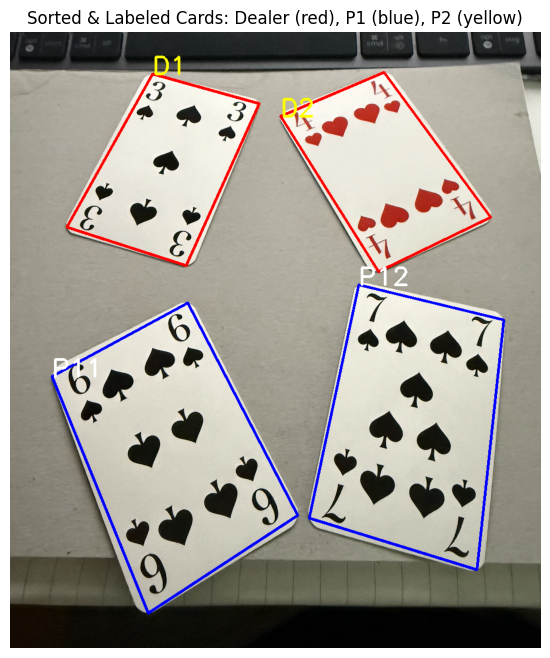

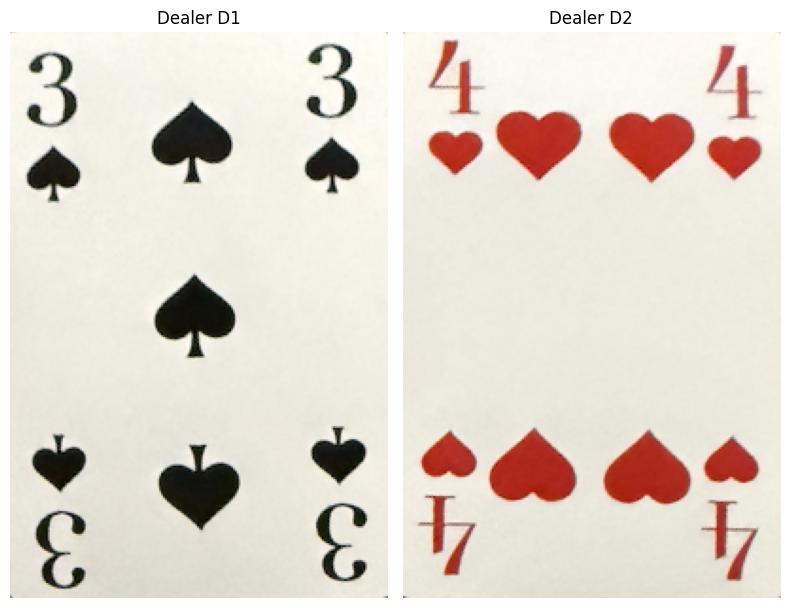

Warped 2 dealer cards to 200×300.


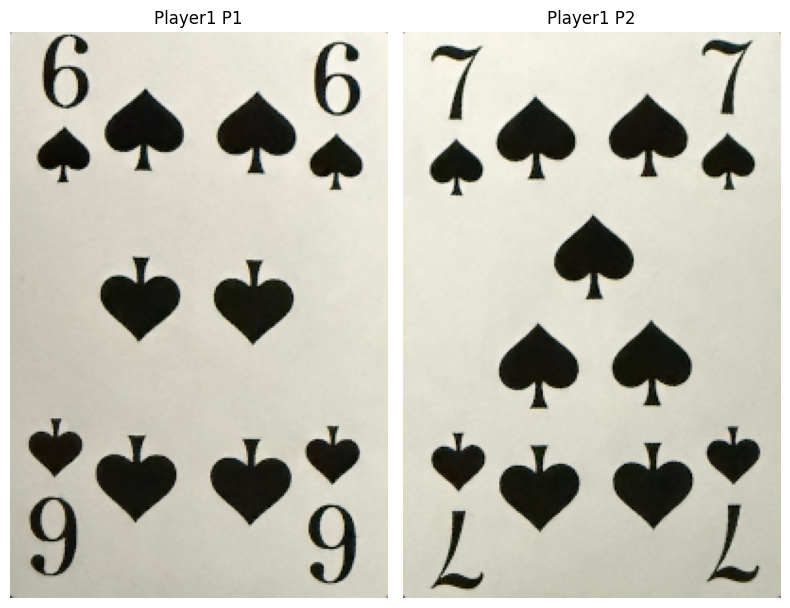

Warped 2 player1 cards to 200×300.


In [39]:
# Sort, Label & Warp Dealer and Player Cards

def order_points(pts):
    """
    Given an array of 4 (x,y) points (unsorted), return a new array in this order:
      top-left, top-right, bottom-right, bottom-left.
    Needed for getPerspectiveTransform.
    """
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)               # sum = x+y
    rect[0] = pts[np.argmin(s)]       # top-left
    rect[2] = pts[np.argmax(s)]       # bottom-right
    diff = np.diff(pts, axis=1)       # diff = y−x
    rect[1] = pts[np.argmin(diff)]    # top-right
    rect[3] = pts[np.argmax(diff)]    # bottom-left
    return rect

def four_point_transform(image, pts, width=200, height=300):
    """
    Perform a perspective transform so that the region defined by the
    four unordered pts in `image` becomes a straight-on view of size
    (width x height).
    """
    rect = order_points(pts)
    dst = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (width, height))

# --- Sort contours left→right ---
dealer_contours = sorted(dealer_contours, key=get_leftmost_x)
# players_contours is a list: [player1_contours] or [player1_contours, player2_contours]
players_sorted = [sorted(lst, key=get_leftmost_x) for lst in players_contours]

# --- Annotate sorted contours on one image ---
annot = original_rgb.copy()
# Dealer: red outline, yellow text
for idx, cnt in enumerate(dealer_contours):
    cv2.drawContours(annot, [cnt], -1, (255, 0, 0), 4)
    pts = cnt.reshape(4, 2)
    tl = tuple(pts[np.argmin(pts.sum(axis=1))])
    cv2.putText(annot, f"D{idx+1}", tl, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 0), 3)

# Players: blue for P1, yellow for P2 (if present)
colors = [(0, 0, 255), (0, 255, 255)]
for p_idx, p_contours in enumerate(players_sorted):
    prefix = f"P{p_idx+1}"
    for idx, cnt in enumerate(p_contours):
        cv2.drawContours(annot, [cnt], -1, colors[p_idx], 4)
        pts = cnt.reshape(4, 2)
        tl = tuple(pts[np.argmin(pts.sum(axis=1))])
        cv2.putText(annot, f"{prefix}{idx+1}", tl, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)

plt.figure(figsize=(10, 8))
plt.imshow(annot)
plt.title('Sorted & Labeled Cards: Dealer (red), P1 (blue), P2 (yellow)')
plt.axis('off')
plt.show()

# --- Warp each group to 200×300 and display ---
groups = [('Dealer', dealer_contours)] + [
    (f"Player{p+1}", players_sorted[p]) for p in range(len(players_sorted))
]

for name, contours in groups:
    warped_imgs = [four_point_transform(original_bgr, cnt.reshape(4,2)) for cnt in contours]
    if not warped_imgs:
        continue
    fig, axes = plt.subplots(1, len(warped_imgs), figsize=(4*len(warped_imgs), 6))
    if len(warped_imgs) == 1:
        axes = [axes]
    for i, card in enumerate(warped_imgs):
        axes[i].imshow(cv2.cvtColor(card, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"{name} {name[0]}{i+1}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Warped {len(warped_imgs)} {name.lower()} cards to 200×300.")


### Perspective Warp & Display of Dealer/Player Cards

- Apply the `four_point_transform` to each dealer contour so that every card appears front-facing at 200×300 pixels (“bird’s-eye view”).  
- Show all warped dealer cards side by side to verify they were extracted and straightened correctly.  
- Repeat the same warp for each player contour, producing a uniform 200×300 image for each.  
- Display all warped player cards together for visual confirmation before template matching.  
- Printing the count ensures we know how many cards were successfully warped in each group.  


### Load & Prepare Card Templates

- Read every rank × suit image in the `PNG-cards/` folder as grayscale and resize to 200×300 to match warped cards.  
- Apply a slight blur so templates undergo the same preprocessing as the detected cards.  
- Discard suit information by grouping templates under their rank key (e.g., ‘A’, ‘2’, ‘J’, etc.), including any alternate artwork variants.  
- Print a summary of how many ranks and template variations were loaded.  
- Display one example template per rank to confirm that the correct images are available for matching.  


Loaded templates for 13 ranks, total of 65 images:
  • 2: 4 variation(s)
  • 3: 4 variation(s)
  • 4: 4 variation(s)
  • 5: 4 variation(s)
  • 6: 4 variation(s)
  • 7: 4 variation(s)
  • 8: 4 variation(s)
  • 9: 4 variation(s)
  • 10: 4 variation(s)
  • A: 5 variation(s)
  • J: 8 variation(s)
  • Q: 8 variation(s)
  • K: 8 variation(s)


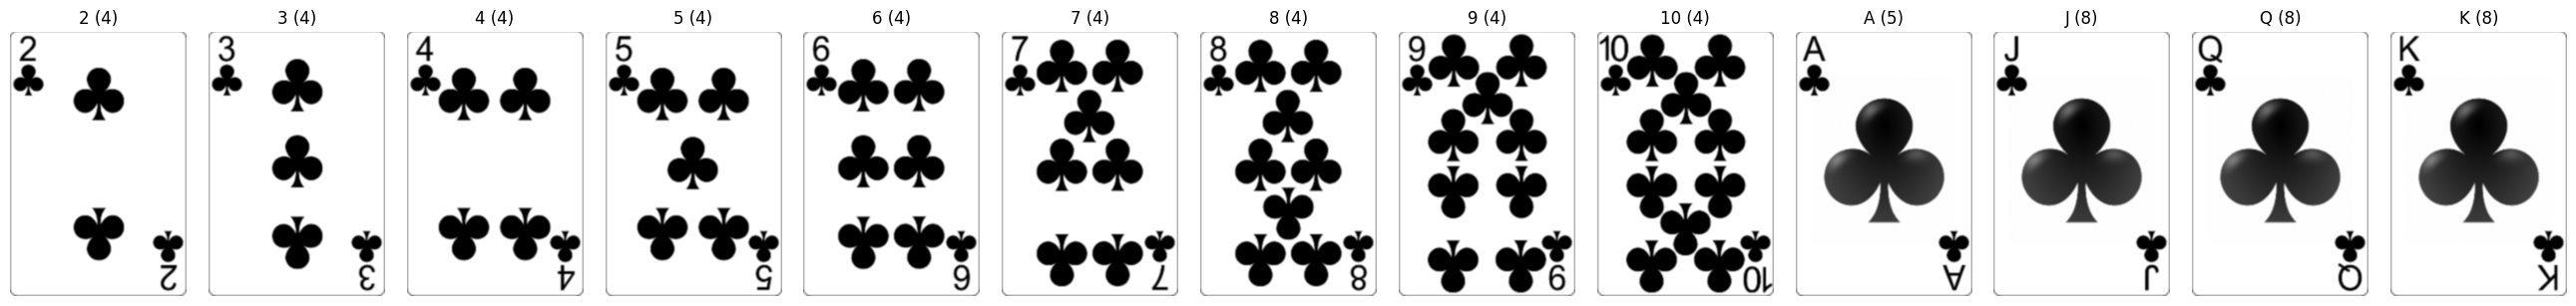

In [40]:
card_templates = {}              # Dictionary: key = rank ('2','3',...'A','J','Q','K'), value = list of template images
template_dir = 'PNG-cards/'      # Folder that contains e.g. 'ace_of_spades.png', '2_of_clubs.png', etc.

# 1. Define all ranks and suits (based on the PNG‐cards naming convention)
ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'ace', 'jack', 'queen', 'king']
suits = ['clubs', 'diamonds', 'hearts', 'spades']

for rank in ranks:
    for suit in suits:
        # Standard filename for each card
        template_name = f'{rank}_of_{suit}.png'
        template_path = os.path.join(template_dir, template_name)
        
        # If template exists, load in grayscale
        if os.path.exists(template_path):
            template_img = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
            # Resize so it matches our warped card size (200×300)
            template_img = cv2.resize(template_img, (200, 300))
            # Blur a bit (this matches how we preprocessed the warped cards)
            template_blurred = cv2.GaussianBlur(template_img, (3, 3), 0)
            
            # Simplify key: for blackjack, suits don’t matter, only rank.
            if rank == 'ace':
                key = 'A'
            elif rank == 'jack':
                key = 'J'
            elif rank == 'queen':
                key = 'Q'
            elif rank == 'king':
                key = 'K'
            else:
                key = rank
            
            # Add to dictionary
            if key not in card_templates:
                card_templates[key] = []
            card_templates[key].append(template_blurred)
        
        # 2. Check variant templates (jack2, queen2, king2, ace_of_spades2)
        #    (some decks have alternate artwork)
        if rank in ['jack', 'queen', 'king'] or (rank == 'ace' and suit == 'spades'):
            if rank == 'ace' and suit == 'spades':
                variant_name = 'ace_of_spades2.png'
            else:
                variant_name = f'{rank}_of_{suit}2.png'
            variant_path = os.path.join(template_dir, variant_name)
            
            if os.path.exists(variant_path):
                variant_img = cv2.imread(variant_path, cv2.IMREAD_GRAYSCALE)
                variant_img = cv2.resize(variant_img, (200, 300))
                variant_blurred = cv2.GaussianBlur(variant_img, (3, 3), 0)
                
                if rank == 'ace':
                    key = 'A'
                elif rank == 'jack':
                    key = 'J'
                elif rank == 'queen':
                    key = 'Q'
                elif rank == 'king':
                    key = 'K'
                
                if key not in card_templates:
                    card_templates[key] = []
                card_templates[key].append(variant_blurred)

# 3. Summary of what we loaded
total_ranks_loaded = len(card_templates)
total_variations = sum(len(v) for v in card_templates.values())
print(f"Loaded templates for {total_ranks_loaded} ranks, total of {total_variations} images:")

for rank, templates in card_templates.items():
    print(f"  • {rank}: {len(templates)} variation(s)")

# 4. Visualize the first template of each rank (grayscale)
fig, axes = plt.subplots(1, total_ranks_loaded, figsize=(2 * total_ranks_loaded, 3))
if total_ranks_loaded == 1:
    axes = [axes]

for i, (rank, templates) in enumerate(card_templates.items()):
    axes[i].imshow(templates[0], cmap='gray')
    axes[i].set_title(f'{rank} ({len(templates)})')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Define Multi‐Metric Scoring for Template Matching

- Implement three similarity metrics between a warped card and a template:  
  - **Normalized Cross‐Correlation** (measures pixel‐level alignment)  
  - **Structural Similarity** via Sobel gradients (captures edge/shape match)  
  - **Histogram Correlation** (compares overall intensity distribution)  
- Combine these three scores into a single weighted score (50% correlation, 30% structural, 20% histogram).  
- Return both the combined score and the individual sub‐scores so we can rank templates and inspect which metric contributed most to each match.  


In [41]:
def correlation_score(card_img, template_img):
    """
    Compute normalized cross‐correlation (NCC) between the card and template.
    Returns a non‐negative score in [0,1].
    """
    # matchTemplate returns a small output; we take its single value [0,0]
    result = cv2.matchTemplate(card_img, template_img, cv2.TM_CCOEFF_NORMED)
    return max(0, result[0, 0])  # clamp to ≥0

def structural_similarity_score(card_img, template_img):
    """
    A simple edge‐based structural similarity: 
    compute Sobel gradients, normalize, then do 1 − mean abs difference.
    Returns a score in [0,1].
    """
    # Compute gradient magnitude of card
    card_grad_x = cv2.Sobel(card_img, cv2.CV_64F, 1, 0, ksize=3)
    card_grad_y = cv2.Sobel(card_img, cv2.CV_64F, 0, 1, ksize=3)
    card_grad = np.sqrt(card_grad_x**2 + card_grad_y**2)
    card_grad /= (np.max(card_grad) + 1e-8)  # normalize to [0,1]
    
    # Compute gradient magnitude of template
    template_grad_x = cv2.Sobel(template_img, cv2.CV_64F, 1, 0, ksize=3)
    template_grad_y = cv2.Sobel(template_img, cv2.CV_64F, 0, 1, ksize=3)
    template_grad = np.sqrt(template_grad_x**2 + template_grad_y**2)
    template_grad /= (np.max(template_grad) + 1e-8)
    
    # Structural similarity = 1 minus average absolute difference
    diff = np.abs(card_grad - template_grad)
    similarity = 1 - np.mean(diff)
    return max(0, similarity)  # clamp to ≥0

def histogram_score(card_img, template_img):
    """
    Compute histogram correlation between the card and template.
    Returns a score in [0,1].
    """
    # Compute 256-bin histograms for each (normalized)
    hist1 = cv2.calcHist([card_img], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([template_img], [0], None, [256], [0, 256])
    hist1 /= (np.sum(hist1) + 1e-8)
    hist2 /= (np.sum(hist2) + 1e-8)
    
    # Use OpenCV to compare histograms with the correlation metric
    corr = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return max(0, corr)

def combined_card_score(card_img, template_img):
    """
    Combine correlation, structural, and histogram scores into one weighted score.
    Weights: 50% correlation, 30% structural, 20% histogram.
    Returns (combined_score, {'corr':…, 'struct':…, 'hist':…})
    """
    corr = correlation_score(card_img, template_img)
    struct = structural_similarity_score(card_img, template_img)
    hist = histogram_score(card_img, template_img)
    
    # Weighted sum
    combined = 0.5 * corr + 0.3 * struct + 0.2 * hist
    return combined, {'corr': corr, 'struct': struct, 'hist': hist}

### Template Matching for Dealer & Player Cards

- Define `match_group_cards` to compare each warped card against all rank templates using the combined scoring function.  
- For each card, record:  
  - The best‐matching rank (highest combined score)  
  - Its combined score and breakdown of correlation, structural, and histogram components  
  - The top-3 ranked candidates for further inspection  
- Print a brief progress update as each card is matched.  
- Run this helper separately on the dealer’s warped cards and the player’s warped cards (converting each to grayscale first), producing `match_results_dealer` and `match_results_player`.  


In [42]:
# --- Cell 6: Match each warped group (Dealer, Player1, Player2, ...) ---

# Safety check: ensure card_templates exists
try:
    card_templates
except NameError:
    raise RuntimeError("card_templates is not defined. Please run the template loading cell first.")

def to_gray(img):
    """
    Convert a BGR or RGBA image to grayscale, or pass through if already single-channel.
    """
    # If it's already 2D, assume it's grayscale
    if img.ndim == 2:
        return img
    # Otherwise convert BGR→GRAY
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def match_group_cards(processed_cards, group_name):
    """
    Given a list of warped grayscale images and a group name,
    returns a list of dicts with:
      • best_rank, best_score, top3, details
    """
    results = []
    for i, card in enumerate(processed_cards, start=1):
        best_rank, best_score, best_details = None, -1.0, None
        rank_scores = {}
        for rank, templates in card_templates.items():
            max_for_rank, detail_for_rank = -1.0, None
            for tmpl in templates:
                score, details = combined_card_score(card, tmpl)
                if score > max_for_rank:
                    max_for_rank, detail_for_rank = score, details
            rank_scores[rank] = max_for_rank
            if max_for_rank > best_score:
                best_score, best_rank, best_details = max_for_rank, rank, detail_for_rank

        top3 = sorted(rank_scores.items(), key=lambda kv: kv[1], reverse=True)[:3]
        results.append({
            'best_rank':  best_rank,
            'best_score': best_score,
            'top3':       top3,
            'details':    best_details
        })
        print(f"{group_name} card {i}: best match = {best_rank} ({best_score:.3f})")
    return results

# Build warped_groups dict (Dealer + Players)
warped_groups = {}
warped_groups['Dealer'] = [four_point_transform(original_bgr, cnt.reshape(4, 2)) for cnt in dealer_contours]
for i, player_contours in enumerate(players_sorted):
    warped_groups[f'Player{i+1}'] = [four_point_transform(original_bgr, cnt.reshape(4, 2)) for cnt in player_contours]

def match_all_groups(warped_groups, card_templates):
    """
    Run template matching for all groups (dealer + N players).
    Returns a dict: {group_name: match_results_list}
    """
    all_results = {}
    for group_name, warped_list in warped_groups.items():
        # Convert all warped cards to grayscale before matching (robust)
        processed_cards = [to_gray(card) for card in warped_list]
        group_results = match_group_cards(processed_cards, group_name)
        all_results[group_name] = group_results
        print(f"→ {group_name} matching done.\n")
    return all_results

# Run matching
all_match_results = match_all_groups(warped_groups, card_templates)

# For backward compatibility
match_results_dealer = all_match_results['Dealer']
# If you have only one player group: match_results_player = all_match_results['Player1']
# For more, use all_match_results['Player2'], etc.


Dealer card 1: best match = 3 (0.513)
Dealer card 2: best match = 4 (0.494)
→ Dealer matching done.

Player1 card 1: best match = 6 (0.506)
Player1 card 2: best match = 7 (0.436)
→ Player1 matching done.



### Display & Interpret Template Matching Results

- Print a clear, formatted summary of each dealer and player card’s predicted rank and overall confidence.  
- Show how much each metric (correlation, structural, histogram) contributed to the final score.  
- List the top‐3 rank candidates for every card to highlight alternative matches.  
- Confirm that multi‐metric template matching has finished for both dealer and player.  


In [43]:
# Enhanced Match Results: Print results for all groups (Dealer + all Players)
print("\n🎯 Enhanced Match Results for All Groups:")
print("=" * 60)

for group_name, results in all_match_results.items():
    print(f"\n🔹 Results for {group_name}:")
    print("-" * 50)
    for idx, result in enumerate(results):
        print(f"\n📊 {group_name} Card {group_name[0]}{idx+1}:")
        print(f"   🏆 Predicted Rank: {result['best_rank']} (Overall: {result['best_score']*100:.1f}%)")
        details = result['details']
        print("   📈 Score Breakdown:")
        print(f"      • Correlation: {details['corr']*100:.1f}%")
        print(f"      • Structural : {details['struct']*100:.1f}%")
        print(f"      • Histogram  : {details['hist']*100:.1f}%")
        print("   🥇 Top 3 Matches:")
        for medal, (rank, score) in zip(["🥇","🥈","🥉"], result['top3']):
            print(f"      {medal} {rank}: {score*100:.1f}%")
        print("-" * 40)

print("\n✅ Multi‐metric matching complete for all groups (Dealer and Players)!")



🎯 Enhanced Match Results for All Groups:

🔹 Results for Dealer:
--------------------------------------------------

📊 Dealer Card D1:
   🏆 Predicted Rank: 3 (Overall: 51.3%)
   📈 Score Breakdown:
      • Correlation: 47.8%
      • Structural : 91.3%
      • Histogram  : 0.0%
   🥇 Top 3 Matches:
      🥇 3: 51.3%
      🥈 2: 43.4%
      🥉 5: 34.9%
----------------------------------------

📊 Dealer Card D2:
   🏆 Predicted Rank: 4 (Overall: 49.4%)
   📈 Score Breakdown:
      • Correlation: 44.5%
      • Structural : 90.6%
      • Histogram  : 0.0%
   🥇 Top 3 Matches:
      🥇 4: 49.4%
      🥈 5: 48.8%
      🥉 6: 47.5%
----------------------------------------

🔹 Results for Player1:
--------------------------------------------------

📊 Player1 Card P1:
   🏆 Predicted Rank: 6 (Overall: 50.6%)
   📈 Score Breakdown:
      • Correlation: 48.1%
      • Structural : 88.4%
      • Histogram  : 0.0%
   🥇 Top 3 Matches:
      🥇 6: 50.6%
      🥈 7: 47.8%
      🥉 8: 45.2%
------------------------------

### Compute Final Blackjack Scores

- Define a mapping of each rank to its blackjack value (Aces start at 11).  
- For each group (dealer and player), sum up the card values based on the matched ranks.  
- If the total exceeds 21 and there are Aces, convert as many Aces from 11→1 as needed to avoid busting.  
- Print each card’s rank, its point value, and the confidence in that match.  
- Display the hand’s total before and after any Ace adjustments, and indicate whether it’s a Blackjack, a bust, or a valid score.  


In [44]:
print("\n🎲 Blackjack Score Calculation:\n" + "="*50)

# 1. Define basic blackjack values for each rank (same as before)
blackjack_values = {
    'A': 11,   # Ace (can become 1 later if needed)
    '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10,
    'J': 10, 'Q': 10, 'K': 10
}

def compute_blackjack_score(match_results, label_prefix):
    """
    Given template-matching results (a list of dicts), compute:
      • total score summing each card’s blackjack value
      • adjust Aces (11→1) if total > 21
      • print details of each card and final status (Blackjack, BUST, or valid)
    Returns the final optimized score.
    """
    total_score = 0
    detected_ranks = []
    
    print(f"\n📋 {label_prefix} Cards and their values:")
    for i, result in enumerate(match_results, start=1):
        rank = result['best_rank']
        confidence = result['best_score'] * 100  # percent
        card_value = blackjack_values[rank]
        total_score += card_value
        detected_ranks.append(rank)
        print(f"   {label_prefix}{i}: {rank} → {card_value} points (confidence: {confidence:.1f}%)")
    
    print(f"\n🎯 {label_prefix} Detected ranks: {', '.join(detected_ranks)}")
    print(f"🏆 {label_prefix} Total (before Ace adjustment): {total_score} points")
    
    # Adjust for Aces if total > 21
    aces_count = detected_ranks.count('A')
    optimized_score = total_score
    if total_score > 21 and aces_count > 0:
        aces_to_convert = min(aces_count, (total_score - 21 + 9) // 10)
        optimized_score = total_score - (aces_to_convert * 10)
        if aces_to_convert > 0:
            print(f"\n🔄 {label_prefix} Ace adjustment:")
            print(f"   Converted {aces_to_convert} Ace(s) from 11→1")
            print(f"   🎯 {label_prefix} Optimized score: {optimized_score} points")
    
    # Final status
    if optimized_score == 21:
        print(f"🎉 {label_prefix} BLACKJACK! Perfect 21!")
    elif optimized_score > 21:
        print(f"💥 {label_prefix} BUST! Score {optimized_score} exceeds 21")
    else:
        print(f"✅ {label_prefix} Valid hand with {optimized_score} points")
    
    print("=" * 50 + "\n")
    return optimized_score

# 2. Compute and print scores for all groups (dealer + all players)
final_scores = {}
for group_name, match_results in all_match_results.items():
    final_score = compute_blackjack_score(match_results, group_name)
    final_scores[group_name] = final_score

# Optionally: print a summary table
print("🏁 Summary of Final Scores:")
for group, score in final_scores.items():
    print(f"   {group}: {score}")



🎲 Blackjack Score Calculation:

📋 Dealer Cards and their values:
   Dealer1: 3 → 3 points (confidence: 51.3%)
   Dealer2: 4 → 4 points (confidence: 49.4%)

🎯 Dealer Detected ranks: 3, 4
🏆 Dealer Total (before Ace adjustment): 7 points
✅ Dealer Valid hand with 7 points


📋 Player1 Cards and their values:
   Player11: 6 → 6 points (confidence: 50.6%)
   Player12: 7 → 7 points (confidence: 43.6%)

🎯 Player1 Detected ranks: 6, 7
🏆 Player1 Total (before Ace adjustment): 13 points
✅ Player1 Valid hand with 13 points

🏁 Summary of Final Scores:
   Dealer: 7
   Player1: 13


### Debug Visualization for Matched Cards

- For every dealer card, display three panels side by side:  
  - The warped card (grayscale) that was processed  
  - Its best‐matched template (first variant)  
  - A bar chart showing the three sub‐scores (correlation, structural, histogram) and the overall confidence  

- Repeat the same layout for each player card to inspect matching quality.  
- This view helps confirm that each card was correctly straightened, matched to the right template, and shows which metric contributed most to that decision.  
- A final printout indicates completion of all visual debug steps.  


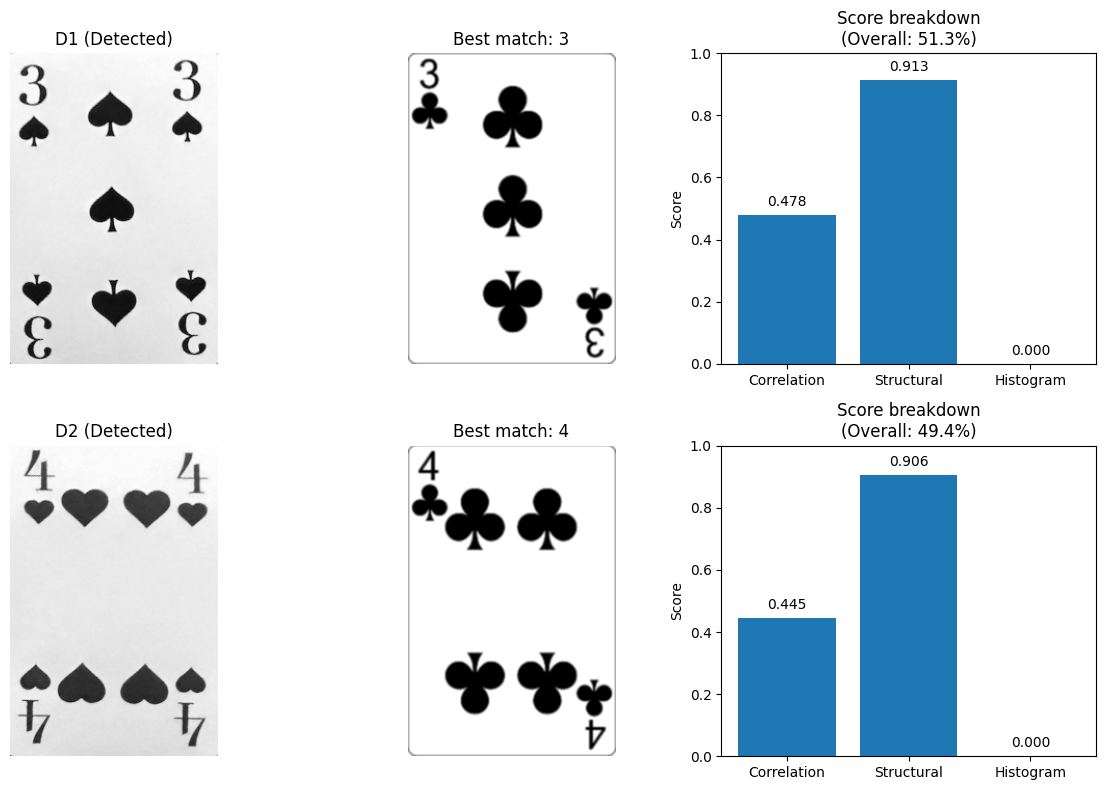

🔍 Dealer debug: displayed 2 cards.


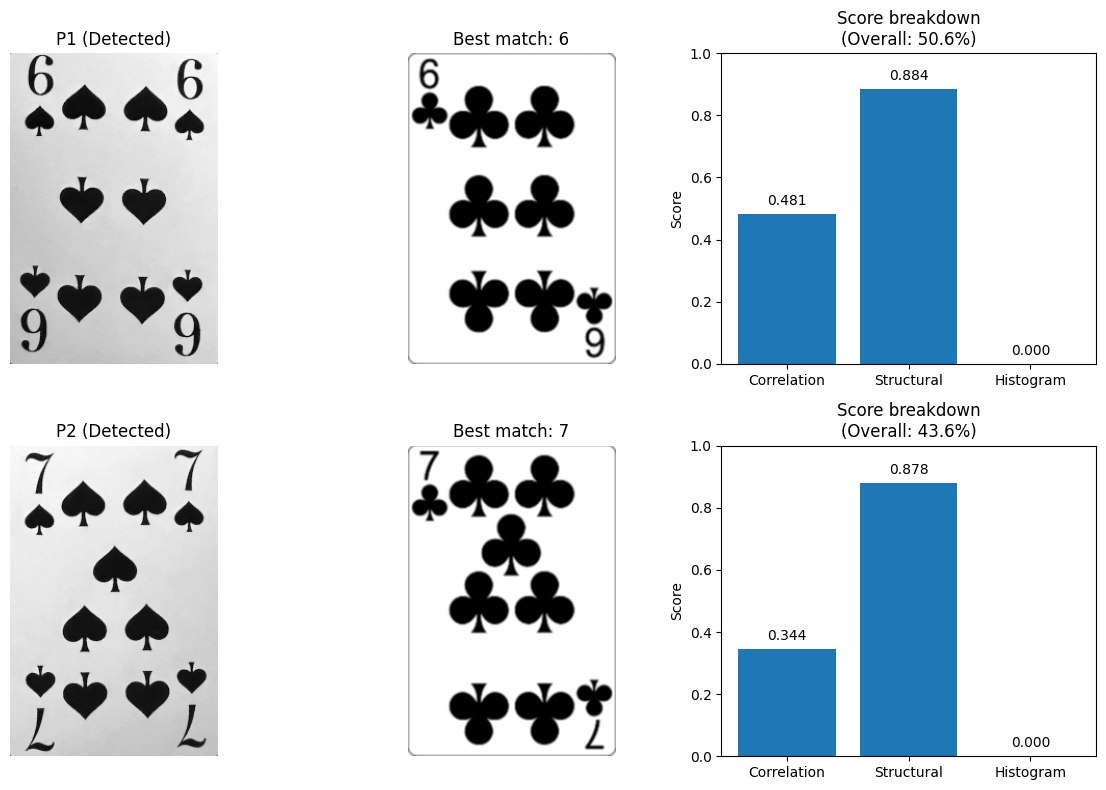

🔍 Player1 debug: displayed 2 cards.

✅ All processing complete for all groups (Dealer and Players)!


In [45]:
# Debug visualization for all groups (Dealer + N players)
for group_name, match_results in all_match_results.items():
    warped_cards = warped_groups[group_name]   # Use the same order as matching!
    if not match_results or not warped_cards:
        continue
    fig, axes = plt.subplots(
        len(match_results),
        3,
        figsize=(12, 4 * len(match_results))
    )
    if len(match_results) == 1:
        axes = axes.reshape(1, -1)

    for idx, result in enumerate(match_results):
        # a) Show processed (warped grayscale) card
        card_gray = cv2.cvtColor(warped_cards[idx], cv2.COLOR_BGR2GRAY)
        axes[idx, 0].imshow(card_gray, cmap='gray')
        axes[idx, 0].set_title(f"{group_name[0]}{idx+1} (Detected)")
        axes[idx, 0].axis('off')
        
        # b) Show the best matching template (first variant for that rank)
        best_rank = result['best_rank']
        best_template = card_templates[best_rank][0]
        axes[idx, 1].imshow(best_template, cmap='gray')
        axes[idx, 1].set_title(f'Best match: {best_rank}')
        axes[idx, 1].axis('off')
        
        # c) Bar chart of (corr, struct, hist)
        details = result['details']
        scores = [details['corr'], details['struct'], details['hist']]
        labels = ['Correlation', 'Structural', 'Histogram']
        bars = axes[idx, 2].bar(labels, scores)
        axes[idx, 2].set_title(f"Score breakdown\n(Overall: {result['best_score']*100:.1f}%)")
        axes[idx, 2].set_ylim(0, 1)
        axes[idx, 2].set_ylabel('Score')
        for bar, sc in zip(bars, scores):
            height = bar.get_height()
            axes[idx, 2].text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.02,
                f"{sc:.3f}",
                ha='center',
                va='bottom'
            )

    plt.tight_layout()
    plt.show()
    print(f"🔍 {group_name} debug: displayed {len(match_results)} cards.")

print("\n✅ All processing complete for all groups (Dealer and Players)!")
